***

***Team Size:*** 3

***

***Team Members:***

0120200160 B234037 Rutuja Yogesh Mahajan

0120200471 B234116 Akanksha Madamanchi

0120200326 B234087 Piyush Bhondave

***

***Title:*** Analyzing Twitter Sentiments with Deep Learning

***


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords

# Importing Dataset

In [ ]:
data = pd.read_csv('Sentiment.csv')

In [ ]:
data = data[['sentiment', 'text']]

In [ ]:
data.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


# Data Preprocessing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# removing neutral data
data = data[data.sentiment != "Neutral"]

# converts to lowercase and removing non-alphanumeric characters
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


# print size of positive and negative data
print("Positive Instances: ", data[ data['sentiment'] == 'Positive'].size)
print("Negative Instances: ", data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

<ipython-input-6-87017289369a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: x.lower())


Positive Instances:  2330
Negative Instances:  8426


# Exploratory Data Analysis

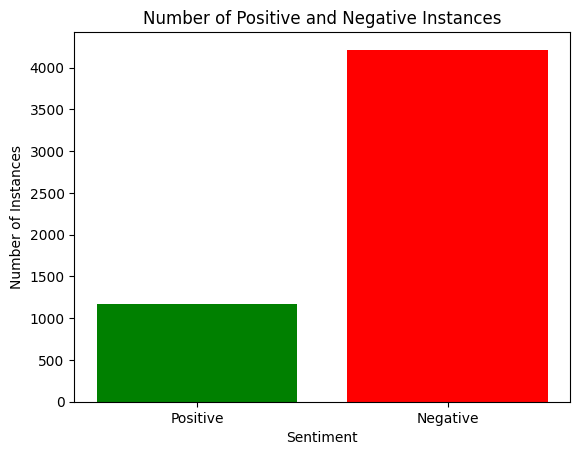

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'data' DataFrame with 'sentiment' column
positive_count = data[data['sentiment'] == 'Positive'].shape[0]
negative_count = data[data['sentiment'] == 'Negative'].shape[0]

# Data for the bar plot
sentiments = ['Positive', 'Negative']
counts = [positive_count, negative_count]

# Plotting the bar plot
plt.bar(sentiments, counts, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.title('Number of Positive and Negative Instances')
plt.show()

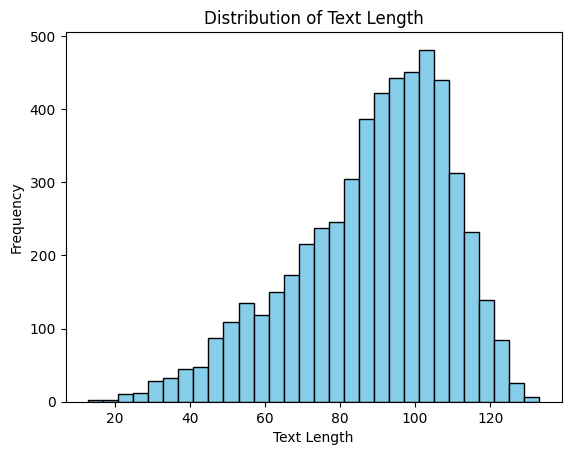

In [ ]:
plt.hist(data['text'].apply(len), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

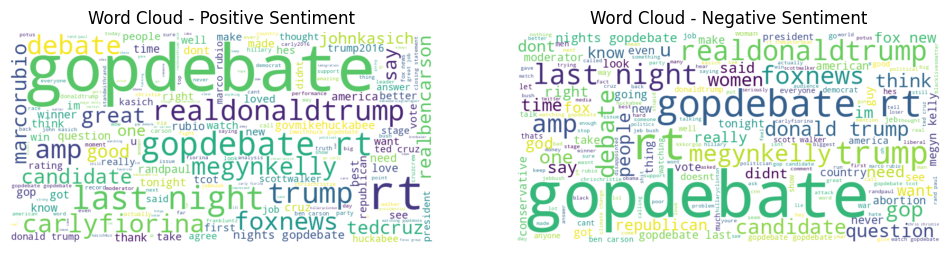

In [ ]:
from wordcloud import WordCloud

positive_text = ' '.join(data[data['sentiment'] == 'Positive']['text'])
negative_text = ' '.join(data[data['sentiment'] == 'Negative']['text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Sentiment')

plt.show()

# Model Creation

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 128)           256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 22, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511194 (1.95 MB)
Trainable params: 511194 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Train-Test Split

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3603, 22) (3603, 2)
(1775, 22) (1775, 2)


# Model Training

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 40, batch_size=batch_size, verbose = 2)

Epoch 1/40
113/113 - 22s - loss: 0.5172 - accuracy: 0.7857 - 22s/epoch - 194ms/step
Epoch 2/40
113/113 - 15s - loss: 0.3720 - accuracy: 0.8421 - 15s/epoch - 132ms/step
Epoch 3/40
113/113 - 15s - loss: 0.2946 - accuracy: 0.8765 - 15s/epoch - 130ms/step
Epoch 4/40
113/113 - 16s - loss: 0.2405 - accuracy: 0.9051 - 16s/epoch - 139ms/step
Epoch 5/40
113/113 - 16s - loss: 0.1998 - accuracy: 0.9206 - 16s/epoch - 141ms/step
Epoch 6/40
113/113 - 18s - loss: 0.1599 - accuracy: 0.9406 - 18s/epoch - 161ms/step
Epoch 7/40
113/113 - 16s - loss: 0.1311 - accuracy: 0.9487 - 16s/epoch - 144ms/step
Epoch 8/40
113/113 - 17s - loss: 0.1099 - accuracy: 0.9578 - 17s/epoch - 146ms/step
Epoch 9/40
113/113 - 17s - loss: 0.0902 - accuracy: 0.9620 - 17s/epoch - 149ms/step
Epoch 10/40
113/113 - 16s - loss: 0.0812 - accuracy: 0.9717 - 16s/epoch - 143ms/step
Epoch 11/40
113/113 - 16s - loss: 0.0703 - accuracy: 0.9728 - 16s/epoch - 138ms/step
Epoch 12/40
113/113 - 16s - loss: 0.0594 - accuracy: 0.9747 - 16s/epoch - 

# Validation

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

# printing score and accuracy agter removing validation data from test data
print("Score: %.2f" % (score))
print("Accuracy: %.2f" % (acc))

9/9 - 1s - loss: 1.3550 - accuracy: 0.7927 - 581ms/epoch - 65ms/step
Score: 1.35
Accuracy: 0.79


In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    # checking if the predicted class index matches the true class index
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    # counting total positive and negative samples
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("Positive accuracy: ", pos_correct/pos_cnt*100, "%")
print("Negative accuracy: ", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 316ms/epoch - 316ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 3

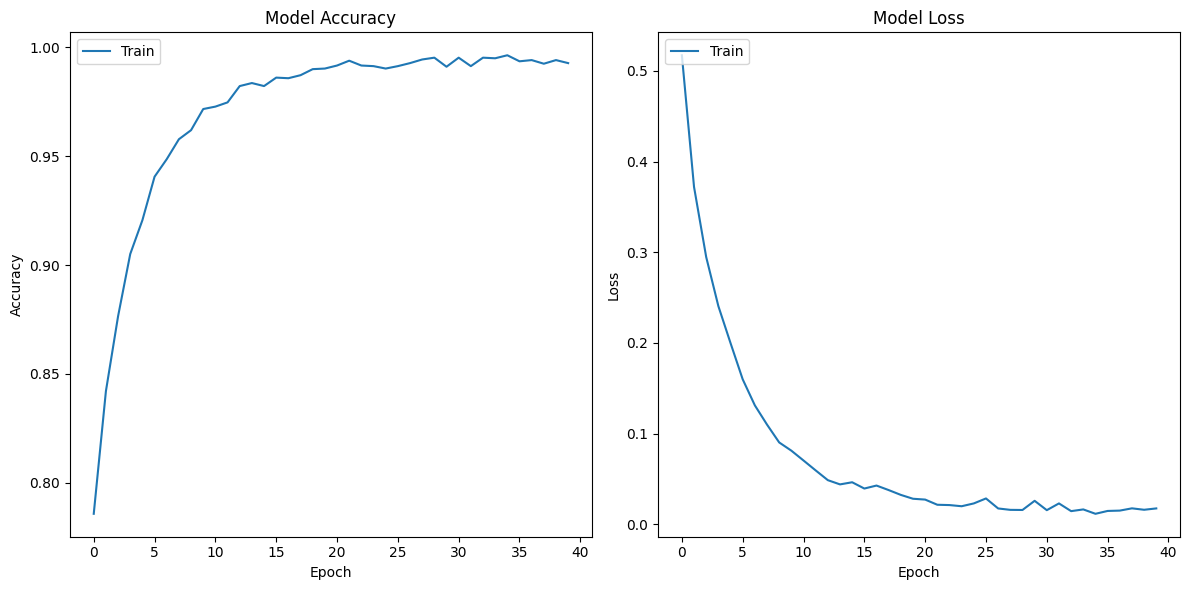

In [ ]:
# Plot training accuracy and loss values
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()


# Prediction

In [ ]:
twt = ["This product is terrible. I regret buying it."]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
#print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Negative")
elif (np.argmax(sentiment) == 1):
    print("Positive")

1/1 - 1s - 508ms/epoch - 508ms/step
Negative


In [ ]:
model.save('mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation and Insights

In [ ]:
# Model Evaluation Metrics and Insights
predicted_probabilities = model.predict(X_test, batch_size=batch_size)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = np.argmax(Y_test, axis=1)

9/9 [==============================] - 1s 32ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


In [ ]:
# Generate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       205
           1       0.62      0.47      0.54        70

    accuracy                           0.79       275
   macro avg       0.73      0.69      0.70       275
weighted avg       0.78      0.79      0.78       275



In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[185  20]
 [ 37  33]]


In [ ]:
# Calculate and print insights
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Precision: 0.62
Recall: 0.47
F1 Score: 0.54


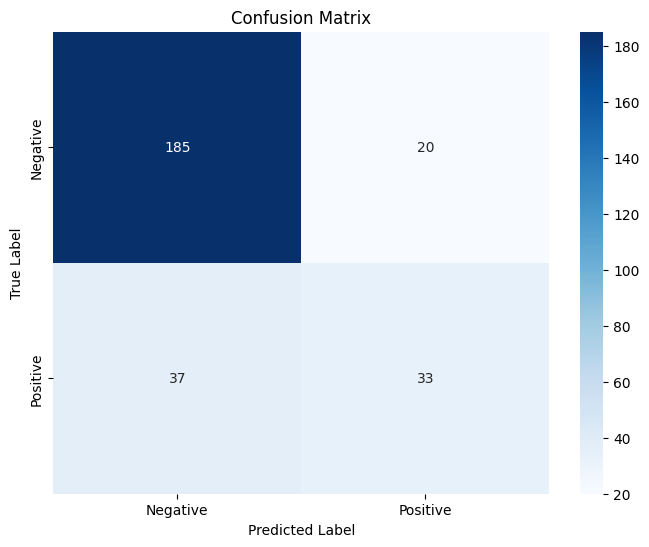

In [ ]:
import seaborn as sns
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()